In [141]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from joblib import dump

print("done")

done


In [142]:
# #read csv
df = pd.read_csv("CH4_ML_dataset_1d.csv")

# # #filter outlier ch4
df = df[df['CH4_flux'] < 2000]

# #remove chamber data 
# # Values to remove
# values_to_remove = ['1', '2', '5', '6']

# # Filter OUT chamber
# df = df[~df['Site'].isin(values_to_remove)]

# Filter TO chamber only
# df = df[df['Site'].isin(values_to_remove)]

# # Group and average data to remove triplicates
df = df.groupby(['Date', 'Site'])[['Latitude', 'Longitude', 'CH4_flux', 'CI', 'Chla.y', 'PAR', 'Kd490', 
                                   'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 
                                   'rtoa9', 'rtoa10', 'rtoa11', 'ADG443', 'TSM', 'pr', 'pr3', 'pr5', 'pr7', 
                                   'tmmx', 'vs']].mean()
df = df.reset_index()

#first 5 rows
# df.head()

#num of rows
print(len(df))

#col names
# print(list(df))

#num of NAs
# print(df.isna().sum())


235


In [143]:
#remove 2 NA rows if using PR 5 or 7
df = df.dropna()

features = df[['CI', 'Chla.y', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'tmmx', 'vs']]

feature_names = ['CI', 'Chla.y', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'tmmx', 'vs']

features = features.to_numpy()

ch4 = df[["CH4_flux"]].to_numpy()

#try log transform
ln_ch4 = np.log(ch4)
#fill NAs (negatives) to 0 
ln_ch4 = np.nan_to_num(ln_ch4, nan=0)

site = df[["Site"]].to_numpy()

rs = 621

#max and min of ch4 
# min_val = np.min(ln_ch4)
# max_val = np.max(ln_ch4)

# print("Minimum value:", min_val)
# print("Maximum value:", max_val)

In [144]:
#%% INITIAL TRAIN-TEST SPLIT (holdout 10% for final training)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, site_train, site_test = train_test_split(
    features, ch4, site, test_size = 0.1, random_state = rs)


In [133]:
#lazy regressor analysis of all models
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

print(models)

 29%|██▊       | 12/42 [00:00<00:02, 13.70it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 62%|██████▏   | 26/42 [00:01<00:01, 10.55it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:03<00:00, 13.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 209, number of used features: 9
[LightGBM] [Info] Start training from score 22.624160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [145]:
# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=110, random_state= rs)

# Train the model
rf_regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(x_test)

# Evaluate the model using R-squared
rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_absolute_error(y_test, y_pred)
print(f"RF Mean Absolute Error: {rf_mse}")
print("RF R-squared:", rf_r2)

from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=rs)

# Train the model
etr.fit(x_train, y_train)

# Make predictions on the test set
etr_y_pred = etr.predict(x_test)

# Evaluate the model using R-squared
etr_r2 = r2_score(y_test, etr_y_pred)
etr_mse = mean_absolute_error(y_test, etr_y_pred)
print(f"ETR Mean Absolute Error: {etr_mse}")
print("ETR R-squared:", etr_r2)

#dump model for raster testing
dump(etr, 'etr_example.joblib')

RF Mean Absolute Error: 14.231698907620745
RF R-squared: 0.38468731694187575
ETR Mean Absolute Error: 11.887641484830354
ETR R-squared: 0.539566619640329


['etr_example.joblib']

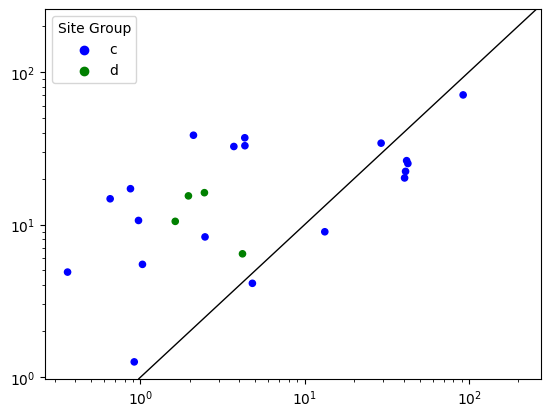

In [135]:
# Error analysis
preds = pd.DataFrame(y_pred, columns=['etr_pred_ch4'])
obs = pd.DataFrame(y_test, columns=['ch4'])
test_features = pd.DataFrame(x_test, columns=feature_names)

error_df = pd.concat([obs.reset_index(drop=True), preds], axis=1)
error_df = pd.concat([test_features.reset_index(drop=True), error_df], axis=1)

site_names = pd.DataFrame(site_test, columns=["Site"]) 
error_df = pd.concat([site_names.reset_index(drop=True), error_df], axis=1)

# Add a column for site group names
error_df["site_group"] = np.where(error_df["Site"].isin(["1", "2", "5", "6"]), "c", "d")

# Map site_group to color
color_map = {'c': 'blue', 'd': 'green'}
colors = error_df['site_group'].map(color_map)

plt.scatter(error_df['ch4'], error_df['etr_pred_ch4'], s=20, c=colors)
plt.axline((0, 0), (200, 200), linewidth=1, color='black')
plt.xscale('log')
plt.yscale('log')

# Optional: add legend manually
for group in color_map:
    plt.scatter([], [], c=color_map[group], label=group)
plt.legend(title='Site Group')

plt.show()

In [136]:
# K fold tests
from sklearn.model_selection import cross_validate, KFold

# Define scoring metrics
scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}

# Initialize the Extra Trees Regressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=rs)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=rs)

# Perform cross-validation and get the scores for multiple metrics
cv_results = cross_validate(etr, x_train, y_train, cv=kf, scoring=scoring)

# Print the cross-validation results
print(f"Cross-Validation Results:")
print(f"R2 Scores: {cv_results['test_R2']}")
print(f"MAE Scores: {cv_results['test_MAE']}")
print(f"MAPE Scores: {cv_results['test_MAPE']}")

# Average the scores
print(f"\nAverage R2: {np.mean(cv_results['test_R2'])}")
print(f"Average MAE: {-np.mean(cv_results['test_MAE'])}")  # MAE is negative in scoring, so negate it
print(f"Average MAPE: {-np.mean(cv_results['test_MAPE'])}") 

# Train the model on the entire training set
etr.fit(x_train, y_train)

# Make predictions on the test set
y_pred = etr.predict(x_test)

# Evaluate the model on the test set
etr_mse = mean_absolute_error(y_test, y_pred)
etr_r2 = r2_score(y_test, y_pred)
print(f"ETR Mean Absolute Error: {etr_mse}")
print("ETR R-squared:", etr_r2)


Cross-Validation Results:
R2 Scores: [-1.62141103e+00 -1.28176425e-03  3.41762079e-02 -1.20034191e+00
 -2.27532720e-02 -1.16793456e+00 -2.47127653e+00 -3.53470574e-01
  5.05434844e-01 -5.70280986e+00]
MAE Scores: [-18.06510382 -26.11893534 -39.70613842 -40.98494496 -31.10760865
 -25.78154806 -34.19969246 -24.0708952  -10.32804841 -24.92599538]
MAPE Scores: [  -6.33631767  -14.52314927  -32.47348888   -9.16877741  -16.38875073
 -799.79119372  -16.27730073 -183.59614238  -18.60494901  -10.42104083]

Average R2: -1.200166845588655
Average MAE: 27.528891068940233
Average MAPE: 110.75811106101312
ETR Mean Absolute Error: 11.887641484830354
ETR R-squared: 0.539566619640329


In [ ]:
#trying bootstrapping
from sklearn.utils import resample

# Initialize the Extra Trees Regressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=rs)

# Bootstrap Resampling (1000 iterations)
n_iterations = 1000
bootstrapped_scores = []

for _ in range(n_iterations):
    # Generate a bootstrap sample
    X_resampled, y_resampled = resample(x_train, y_train, random_state=rs)
    
    # Train model on the resampled dataset
    etr.fit(X_resampled, y_resampled)
    
    # Evaluate the model
    y_pred = etr.predict(x_test)
    
    # Store the Mean Absolute Error
    score = mean_absolute_error(y_test, y_pred)
    bootstrapped_scores.append(score)

# Compute the mean and standard deviation of the bootstrapped scores
mean_bootstrap_score = np.mean(bootstrapped_scores)
std_bootstrap_score = np.std(bootstrapped_scores)

print(f"Bootstrapped Mean MAE: {mean_bootstrap_score}")
print(f"Bootstrapped MAE Standard Deviation: {std_bootstrap_score}")

# Final model training on full training set
etr.fit(x_train, y_train)

# Evaluate the model on the test set
etr_mse = mean_absolute_error(y_test, y_pred)
etr_r2 = r2_score(y_test, y_pred)
print(f"ETR Mean Absolute Error: {etr_mse}")
print("ETR R-squared:", etr_r2)

Text(0.5, 1.0, 'ETR')

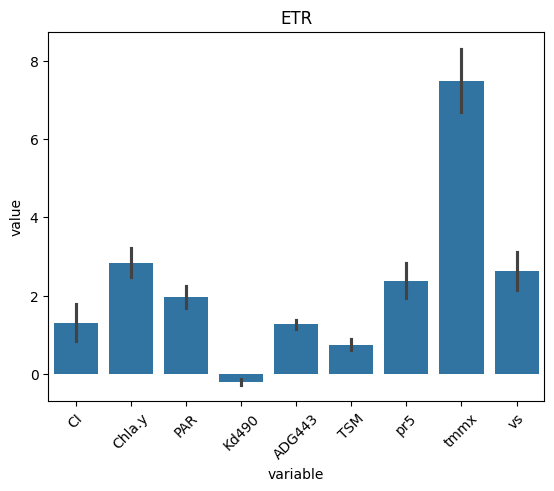

In [137]:
#%% FEATURE IMPORTANCE 
from sklearn.inspection import permutation_importance
import seaborn as sns

scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}

result = permutation_importance(
    etr, x_test, y_test,
    n_repeats=50, 
    random_state=rs, 
    n_jobs=-1,
    scoring=scoring)

#%% Plot RF importances
rf_perm_imp = pd.DataFrame(result['MAE']['importances'], index=feature_names).T

perm_imp_long = pd.melt(rf_perm_imp)
g = sns.barplot(data = perm_imp_long, x = 'variable',y='value')
plt.xticks(rotation=45)
plt.title("ETR")

Text(0.5, 1.0, 'ETR - Discrete Only')

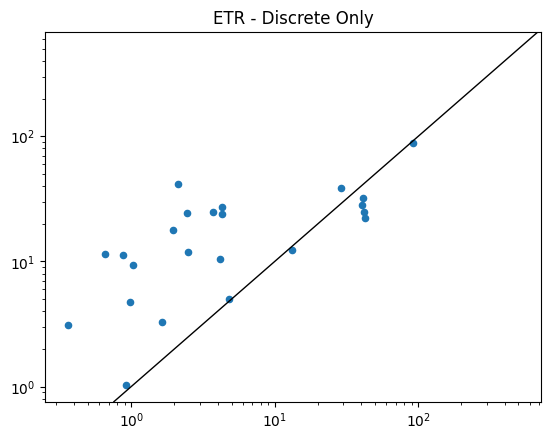

In [138]:
#%% PLOT BEST ETR PERFORMANCE
#https://stackoverflow.com/questions/19064772/visualization-of-scatter-plots-with-overlapping-points-in-matplotlib
from scipy import stats

values = np.vstack([y_test.ravel(), y_pred.ravel()])
kernel = stats.gaussian_kde(values, bw_method=.02)(values)

plt.scatter(y_test, y_pred, s=20)
plt.axline((0,0), (500,500), linewidth=1, color='black')
# plt.axis((0,50,0,50))
plt.xscale('log')
plt.yscale('log')
plt.title("ETR - Discrete Only")

# plt.savefig('log_randomforest_plot.png')

In [ ]:
#%% RANDOM SEARCH CV ETR
from sklearn.model_selection import RandomizedSearchCV

#define scoring metrics
scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 7, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
etr = ExtraTreesRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
etr_random = RandomizedSearchCV(estimator = etr, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, 
                               verbose=2, scoring = scoring,
                                refit = "MAE",
                               random_state=rs, n_jobs = -1)

# Fit the random search model
etr_random.fit(x_train, y_train.ravel())

#%%
etr_random.best_params_

In [140]:
# Best ETR
# Create an Extra Trees Regressor model
best_etr = ExtraTreesRegressor(n_estimators=600, 
                          min_samples_split = 2,
                          min_samples_leaf = 1,
                          max_features = 'sqrt',
                          max_depth = 30,
                          random_state=rs)

# Train the model
best_etr.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_etr.predict(x_test)

# Evaluate the model
etr_mse = mean_absolute_error(y_test, y_pred)
etr_r2 = r2_score(y_test, y_pred)
print(f"ETR Mean Absolute Error: {etr_mse}")
print("ETR R-squared:", etr_r2)

ETR Mean Absolute Error: 12.22805653810431
ETR R-squared: 0.4778586632718813


Text(0.5, 1.0, 'Best ETR')

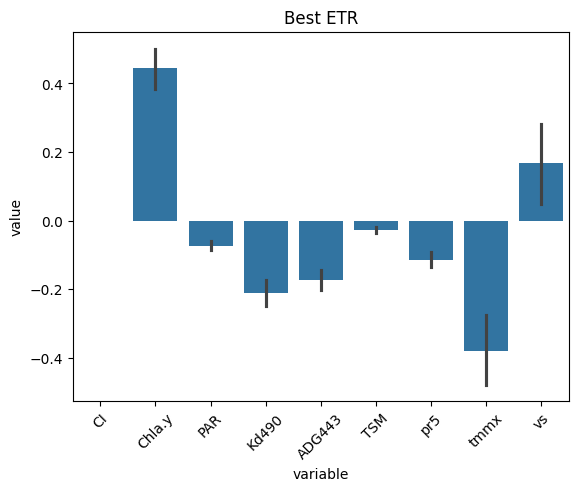

In [129]:
result = permutation_importance(
    best_etr, x_test, y_test,
    n_repeats=50, 
    random_state=rs, 
    n_jobs=-1,
    scoring=scoring)

#%% Plot RF importances
rf_perm_imp = pd.DataFrame(result['MAE']['importances'], index=feature_names).T

perm_imp_long = pd.melt(rf_perm_imp)
g = sns.barplot(data = perm_imp_long, x = 'variable',y='value')
plt.xticks(rotation=45)
plt.title("Best ETR")

In [ ]:
# #write obs vs pred to csv for manual stat calc
best_rf_csv = pd.DataFrame(y_pred, columns=['pred_ch4'])
y_test_csv = pd.DataFrame(y_test, columns=['ch4'])
best_rf_csv = pd.concat([y_test_csv.reset_index(drop=True), best_rf_csv], axis=1)

best_rf_csv.to_csv('etr_obs_vs_pred.csv', index = False)

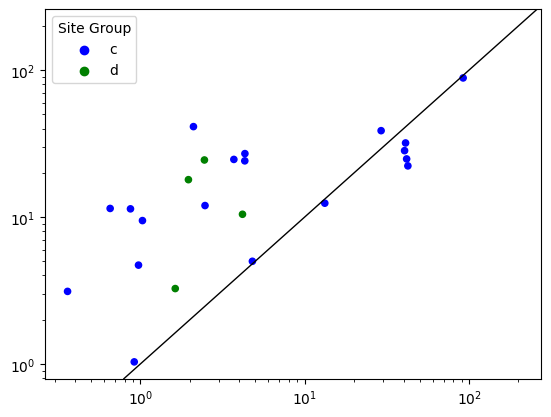

In [ ]:
# Error analysis plot
# plt.scatter(error_df['ch4'], error_df['etr_pred_ch4'], s=20, c = error_df['site_group'])
# plt.axline((0,0), (200,200), linewidth=1, color='black')
# # plt.legend(loc='upper left')
# plt.colorbar()
# plt.xscale('log')
# plt.yscale('log')
# plt.show()
